In [1]:
% matplotlib inline

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
from dataloader import load_data
import matplotlib.pyplot as plt
import seaborn as sns
from evaluate import *

In [3]:
sns.set_style("ticks")
dark_palette = np.array(sns.color_palette("dark", 8))[np.array([0,2,1,3,4,5,6,7]),:]
deep_palette = np.array(sns.color_palette("deep", 8))[np.array([0,2,1,3,4,5,6,7]),:]
sns.set_palette(dark_palette)
plt_colors = sns.color_palette()
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams.update({'font.size': 12})

In [4]:
X, y, w, t, cens = {}, {}, {}, {}, {}

In [5]:
buckets_ml, buckets_conv, arrs_ml, arrs_conv = {}, {}, {}, {}
pvals_ml, pvals_conv = {}, {}
cox = {}
framingham = {}
ascvd = {}

In [6]:
pred_rr_ml = {}
pred_rr_conv = {}

In [31]:
for dataset in ("combined", "sprint", "accord"):
  
  X[dataset] = np.load("results/xlearner/%s/X.npy" % dataset)
  w[dataset] = np.load("results/xlearner/%s/w.npy" % dataset)
  y[dataset] = np.load("results/xlearner/%s/y.npy" % dataset)
  t[dataset] = np.load("results/xlearner/%s/t.npy" % dataset)
  cens[dataset] = np.load("results/xlearner/%s/cens.npy" % dataset)
  
  cox[dataset] = np.load("results/baselines/%s/coxph.npy" % dataset)
  framingham[dataset] = np.load("results/baselines/%s/framingham.npy" % dataset)
  ascvd[dataset] = np.load("results/baselines/%s/ascvd.npy" % dataset)
  
  pred_rr_ml[dataset] = np.load("results/xlearner/%s/pred_rr.npy" % dataset)
  pred_rr_conv[dataset] = np.load("results/cox/%s/pred_rr.npy" % dataset)
  
  buckets_ml[dataset] = np.load("results/xlearner/%s/buckets.npy" % dataset)
  arrs_ml[dataset] = np.load("results/xlearner/%s/arrs.npy" % dataset).item()
  pvals_ml[dataset] = np.load("results/xlearner/%s/pvals.npy" % dataset)
  buckets_conv[dataset] = np.load("results/cox/%s/buckets.npy" % dataset)
  arrs_conv[dataset] = np.load("results/cox/%s/arrs.npy" % dataset).item()
  pvals_conv[dataset] = np.load("results/cox/%s/pvals.npy" % dataset)

FileNotFoundError: [Errno 2] No such file or directory: 'results/cox/accord/buckets.npy'

In [9]:
def calc_corr_in_pred_rr(dataset):
  print(stats.pearsonr(pred_rr_ml[dataset], pred_rr_conv[dataset]))

In [10]:
calc_corr_in_pred_rr("combined")

(0.18271396209698715, 1.9211304055529257e-102)


In [19]:
# def plot_obs_rr_across_buckets(dataset, n_trials=10000):
#   """
#   Plot observed risk reduction
#   """
#   buckets, types, risk_reductions, lengths = [], [], [], []
#   for bucket in [NOEFF_ASSIGNMENT, BENEFIT_ASSIGNMENT]:
#     buckets += [bucket] * n_trials
#     types += ["ml"] * n_trials
#     risk_reductions += arrs_ml[dataset][bucket]
#     lengths.append(np.sum(buckets_ml[dataset] == bucket))
#   for bucket in [NOEFF_ASSIGNMENT, BENEFIT_ASSIGNMENT]:
#     buckets += [bucket] * n_trials
#     types += ["conv"] * n_trials
#     risk_reductions += arrs_conv[dataset][bucket]
#     lengths.append(np.sum(buckets_conv[dataset] == bucket))
#   plt.figure(figsize=(6, 4))
#   sns.boxplot(x=buckets, y=risk_reductions, hue=types, palette="deep",
#               showfliers=False)
#   xtick_labels = ["No benefit (N={}/{})".format(lengths[0], lengths[2]),
#                   "Benefit (N={}/{})".format(lengths[1], lengths[3])]
#   plt.xticks(np.arange(2), xtick_labels)
#   plt.axhline(y=0.0, linestyle="--", color="grey")
#   plt.title("{}: observed risk reduction across predicted buckets".format(dataset.upper()))
#   plt.savefig("./img/{}_obs_rr_across_buckets.pdf".format(dataset))

In [34]:
def forest_plot(dataset):
  n_trials = len(arrs_ml[dataset][BENEFIT_ASSIGNMENT])
  buckets, risk_reductions, lengths = [], [], []
  buckets += [1] * n_trials
  risk_reductions += arrs_ml[dataset][BENEFIT_ASSIGNMENT]
  lengths.append(np.sum(buckets_ml[dataset] == BENEFIT_ASSIGNMENT))
  buckets += [2] * n_trials
  risk_reductions += arrs_conv[dataset][BENEFIT_ASSIGNMENT]
  lengths.append(np.sum(buckets_conv[dataset] == BENEFIT_ASSIGNMENT))
  buckets += [4] * n_trials
  risk_reductions += arrs_ml[dataset][NO_BENEFIT_ASSIGNMENT]
  lengths.append(np.sum(buckets_ml[dataset] == NO_BENEFIT_ASSIGNMENT))
  buckets += [5] * n_trials
  risk_reductions += arrs_conv[dataset][NO_BENEFIT_ASSIGNMENT]
  lengths.append(np.sum(buckets_conv[dataset] == NO_BENEFIT_ASSIGNMENT))
  buckets = np.array(buckets)
  risk_reductions = np.array(risk_reductions)
  ytick_labels = [
    "$\mathbf{Benefit}$",
    "    Machine Learning",
    "    Conventional",
    "$\mathbf{No\ benefit}$   ",
    "    Machine Learning", 
    "    Conventional"]
  ytick_locs = [-0, -1,-1.5,-3,-4,-4.5]
  fig = plt.figure(figsize=(12, 4), tight_layout=True)
  pvals = {
    1: pvals_ml[dataset][0],
    2: pvals_conv[dataset][0],
    4: pvals_ml[dataset][1],
    5: pvals_conv[dataset][1]
  }
  minsofar, maxsofar = 0, 0
  for i, b in enumerate([1,2,4,5]):
    rng = get_range(risk_reductions[buckets == b])
    minsofar = min(minsofar, np.min(rng))
    maxsofar = max(maxsofar, np.max(rng))
    plt.plot(rng, [ytick_locs[b]] * 3, "-|", 
             color=plt_colors[0] if b == 1 or b == 4 else plt_colors[1])
    plt.plot([rng[1]], ytick_locs[b], "D", 
             color=plt_colors[0] if b == 1 or b == 4 else plt_colors[1])
  for i, b in enumerate([1,2,4,5]):
    rng = get_range(risk_reductions[buckets == b])
    plt.text(maxsofar + 0.01, ytick_locs[b], 
             "{:.4f} [{:.4f} {:.4f}], $P$ = {:.2f}, $N$ = {}".format(
               rng[1],rng[0], rng[2], pvals[b], lengths[i]))
  ax = fig.get_axes()[0]
  ax.set_yticks([-0, -1,-1.5,-3,-4,-4.5])
  r = ax.set_yticklabels(ytick_labels, ha = 'left')
  plt.draw()
  ax.tick_params(axis=u'y', which=u'both',length=0)
  yax = ax.get_yaxis()
  pad = max(T.label.get_window_extent().width + 5 for T in yax.majorTicks)
  yax.set_tick_params(pad=pad)
  plt.xlabel("Average Risk Reduction")
  plt.xlim([-0.07, 0.15])
  plt.ylim([-5.5,0.5])
  plt.axvline(x=0.0, linestyle="--", color="grey")
  plt.savefig("./img/{}_forest_plot.pdf".format(dataset))

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


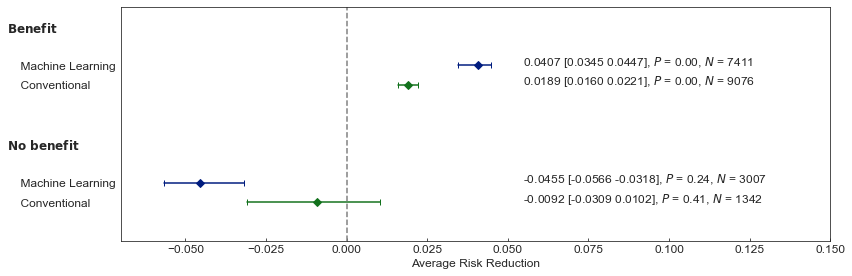

In [35]:
forest_plot("combined")

In [126]:
def plot_expected_vs_obs_rr(dataset, n_bins=5, bin_strategy="rr"):
  plt.figure(figsize=(12, 4))
  plt.subplot(1,2,1)
  rss, slope, intercept, pred_rr, obs_rr, = calibration(pred_rr_ml[dataset], 
                                                        y[dataset],
                                                        w[dataset], 
                                                        t[dataset],
                                                        365.25 * 3, n_bins=5)
  plt.scatter(pred_rr, obs_rr, alpha=0.5, color=plt_colors[0])
  abline_values = [slope * i + intercept for i in [-0.15, 0.25]]
  plt.plot([-0.15, 0.25], abline_values, '--', color=plt_colors[0])
  plt.title("Machine Learning", fontsize=12, fontweight="bold")
  plt.xlim([-0.15,0.20])
  plt.ylim([-0.15,0.20])
  plt.text(-0.12, 0.15, "Slope: {:.2f}, Intercept: {:.2f}".format(slope, intercept))
  plt.xlabel("Predicted ARR")
  plt.ylabel("Observed ARR")
  plt.plot((-0.3,0.3), (-0.3, 0.3), "--", color="grey")
  plt.subplot(1,2,2)
  rss, slope, intercept, pred_rr, obs_rr, = calibration(pred_rr_conv[dataset], 
                                                        y[dataset],
                                                        w[dataset], 
                                                        t[dataset],
                                                        365.25 * 3, n_bins=5)
  rss = np.sum((np.array(obs_rr) - np.array(pred_rr)) ** 2)
  plt.scatter(pred_rr, obs_rr, alpha=0.5, color=plt_colors[1])
  abline_values = [slope * i + intercept for i in [-0.15, 0.25]]
  plt.plot([-0.15, 0.25], abline_values, '--', color=plt_colors[1])
  plt.title("Conventional", fontsize=12, fontweight="bold")
  plt.xlim([-0.15,0.20])
  plt.ylim([-0.15,0.20])
  plt.xlabel("Predicted ARR")
  plt.ylabel("Observed ARR")
  plt.text(-0.12, 0.15, "Slope: {:.2f}, Intercept: {:.2f}".format(slope, intercept))
  plt.plot((-0.3,0.3), (-0.3, 0.3), "--", color="grey")
  plt.savefig("./img/{}_calibration_curve_by_pred_risk.pdf".format(dataset))

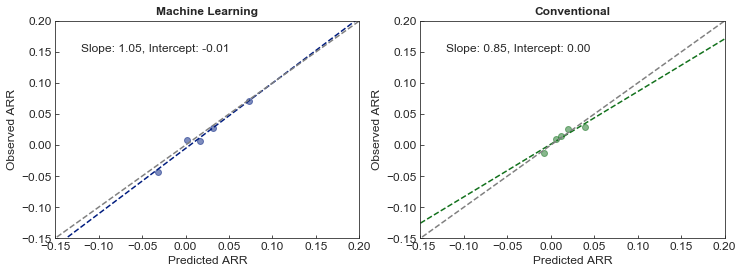

In [127]:
plot_expected_vs_obs_rr("combined", bin_strategy="rr")

In [164]:
def plot_pred_rr_against_baseline_decile(dataset, baseline_risk=cox, n_bins=10):
  bins = np.percentile(baseline_risk[dataset], q=np.linspace(0, 100, n_bins + 1))
  baseline_decile = np.linspace(0, 100, n_bins + 1)[np.digitize(baseline_risk[dataset], bins[:-1]) - 1]
  baseline_decile[baseline_decile == 2] = 0
  plt.figure(figsize=(10, 4))
  plt.axhline(y=0.0, linestyle="--", color="grey")
  sns.boxplot(x=np.r_[baseline_decile, baseline_decile] / 10 + 1, 
              y=np.r_[pred_rr_ml[dataset], pred_rr_conv[dataset]], 
              hue=np.r_[["Machine Learning"] * len(pred_rr_ml[dataset]), 
                        ["Conventional"] * len(pred_rr_conv[dataset])], 
              palette=deep_palette,
              showfliers=False)
  plt.ylabel("Predicted ARR")
  plt.xlabel("Baseline Risk Decile")
  plt.ylim((-0.15, 0.20))
  plt.savefig("./img/{}_pred_rr_baseline_decile.pdf".format(dataset))

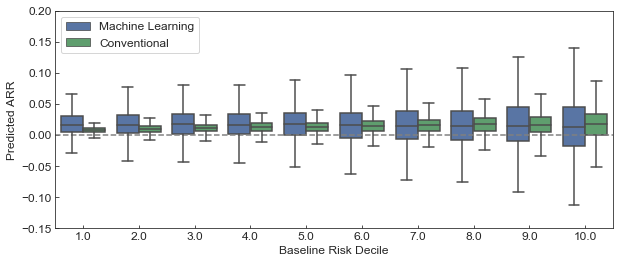

In [165]:
plot_pred_rr_against_baseline_decile("combined")

In [50]:
def plot_predicted_rr(dataset):
  plt.figure(figsize=(8, 4))
  pred_rr = pred_rr_ml[dataset]
  sns.kdeplot(pred_rr, label="Machine Learning", shade=True)
  pred_rr = pred_rr_conv[dataset]
  sns.kdeplot(pred_rr, label="Conventional", shade=True)
  plt.ylabel("Density")
  plt.xlabel("Predicted absolute risk reduction")
  plt.xlim([-0.15, 0.15])
  plt.legend()
  plt.savefig("./img/{}_pred_rr_distributions.pdf".format(dataset))

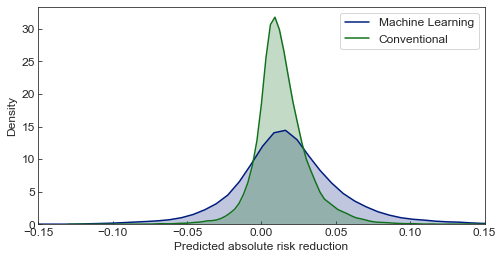

In [76]:
plot_predicted_rr("combined")

In [77]:
# def plot_predicted_rr_conv():
#   plt.figure(figsize=(8, 4))
#   pred_rr_sprint = pred_rr_conv["sprint"]
#   low, high = np.percentile(pred_rr_sprint, 1), np.percentile(pred_rr_sprint, 99)
#   plt.hist(pred_rr_sprint[np.logical_and(low < pred_rr_sprint, high > pred_rr_sprint)], 
#            bins=30, normed=True, alpha=0.5, label="SPRINT", edgecolor="none",
#            color=plt_colors[5])
#   pred_rr_accord = pred_rr_conv["accord"]
#   low, high = np.percentile(pred_rr_accord, 2.5), np.percentile(pred_rr_accord, 97.5)
#   plt.hist(pred_rr_accord[np.logical_and(low < pred_rr_accord, high > pred_rr_accord)], 
#            bins=30, normed=True, alpha=0.5, label="ACCORD", edgecolor="none",
#            color=plt_colors[2])
#   pred_rr_accord = pred_rr_conv["combined"]
#   low, high = np.percentile(pred_rr_accord, 2.5), np.percentile(pred_rr_accord, 97.5)
#   plt.hist(pred_rr_accord[np.logical_and(low < pred_rr_accord, high > pred_rr_accord)], 
#            bins=30, normed=True, alpha=0.5, label="COMBINED", edgecolor="none",
#            color=plt_colors[3])
#   plt.ylabel("Density")
#   plt.xlabel("Predicted absolute risk reduction")
#   plt.title("Conventional: Distributions of predicted absolute risk reduction")
#   plt.xlim([-0.2,0.2])
#   plt.savefig("./img/conv_pred_rr_distributions.pdf")
#   plt.legend()

In [8]:
def calculate_summary_stats(dataset, bucket=True):
  cols = load_data("accord")["cols"]
  if bucket:
    print("== ml [BEN | NOEFF]")
    print(sum(pred_rr_ml[dataset] > 0))
    print(sum(pred_rr_ml[dataset] <= 0))
    for i, col in enumerate(cols):
      ben = X[dataset][:,i][pred_rr_ml[dataset] > 0]
      noeff = X[dataset][:,i][pred_rr_ml[dataset] <= 0]
      print("{}:,{:.2f} ({:.2f}),{:.2f} ({:.2f})".format(col, ben.mean(), ben.std(),
                                                           noeff.mean(), noeff.std()))
    print("== conv [BEN | NOEFF]")
    print(sum(pred_rr_conv[dataset] > 0))
    print(sum(pred_rr_conv[dataset] <= 0))
    for i, col in enumerate(cols):
      ben = X[dataset][:,i][pred_rr_conv[dataset] > 0]
      noeff = X[dataset][:,i][pred_rr_conv[dataset] <= 0]
      print("{}:,{:.2f} ({:.2f}),{:.2f} ({:.2f})".format(col, ben.mean(), ben.std(),
                                                              noeff.mean(), noeff.std()))
  else:
    for i, col in enumerate(cols):
      print("{}:,{:.2f} ({:.2f})".format(col, X[dataset][:,i].mean(),
                                              X[dataset][:,i].std()))

In [12]:
calculate_summary_stats("combined", bucket=True)

== ml [BEN | NOEFF]
9983
3621
AGE:,66.59 (9.15),65.46 (7.96)
FEMALE:,0.39 (0.49),0.43 (0.50)
RACE_BLACK:,0.30 (0.46),0.26 (0.44)
hisp:,0.09 (0.29),0.10 (0.30)
SBP.y:,141.17 (16.05),135.43 (13.60)
DBP.y:,78.89 (11.24),73.35 (11.11)
N_AGENTS:,1.77 (1.05),1.84 (1.05)
currentsmoker:,0.10 (0.30),0.07 (0.26)
formersmoker:,0.44 (0.50),0.45 (0.50)
ASPIRIN:,0.51 (0.50),0.53 (0.50)
STATIN:,0.45 (0.50),0.66 (0.47)
SCREAT:,1.01 (0.31),1.04 (0.35)
CHR:,191.75 (41.31),189.04 (44.18)
HDL:,51.86 (14.30),47.85 (14.39)
TRR:,131.94 (76.82),186.16 (197.47)
BMI:,30.64 (5.76),30.69 (5.81)
diabetes:,0.27 (0.45),0.50 (0.50)
== conv [BEN | NOEFF]
11930
1674
AGE:,66.51 (8.86),64.72 (8.72)
FEMALE:,0.38 (0.49),0.55 (0.50)
RACE_BLACK:,0.31 (0.46),0.17 (0.37)
hisp:,0.04 (0.19),0.51 (0.50)
SBP.y:,139.77 (15.66),138.73 (15.51)
DBP.y:,77.66 (11.52),75.71 (10.95)
N_AGENTS:,1.76 (1.05),1.98 (1.02)
currentsmoker:,0.09 (0.29),0.08 (0.27)
formersmoker:,0.45 (0.50),0.39 (0.49)
ASPIRIN:,0.51 (0.50),0.52 (0.50)
STATIN:,0.47 (

In [14]:
calculate_summary_stats("accord", bucket=False)

AGE:,63.19 (6.68)
FEMALE:,0.49 (0.50)
RACE_BLACK:,0.24 (0.42)
hisp:,0.07 (0.26)
SBP.y:,139.62 (15.75)
DBP.y:,75.94 (10.34)
N_AGENTS:,1.70 (1.08)
currentsmoker:,0.01 (0.10)
formersmoker:,0.48 (0.50)
ASPIRIN:,0.52 (0.50)
STATIN:,0.65 (0.48)
SCREAT:,0.91 (0.25)
CHR:,192.88 (43.77)
HDL:,46.74 (13.50)
TRR:,186.86 (164.58)
BMI:,32.23 (5.46)
diabetes:,1.00 (0.00)


In [145]:
def plot_matching_patient_pairs(dataset):
  random.seed(1)
  plt.figure(figsize=(11, 4))
  plt.subplot(1,2,1)
  tuples = list(zip(pred_rr_ml[dataset][cens[dataset] == 0], 
                    y[dataset][cens[dataset] == 0], 
                    w[dataset][cens[dataset] == 0]))
  untreated = list(filter(lambda t: t[2] == 0, tuples))
  treated = list(filter(lambda t: t[2] == 1, tuples))
  if len(treated) < len(untreated):
    untreated = random.sample(untreated, len(treated))
  if len(untreated) < len(treated):
    treated = random.sample(treated, len(untreated))
  assert len(untreated) == len(treated)
  untreated = sorted(untreated, key=lambda t: t[0])
  treated = sorted(treated, key=lambda t: t[0])
  plt.scatter(np.array(treated)[:,0], np.array(untreated)[:,0], marker=".", alpha=1e-2)
  plt.plot((-0.3, 0.3), (-0.3, 0.3), "--", color="grey")
  plt.xlabel("Predicted ARR, intensive arm")
  plt.ylabel("Predicted ARR, standard arm")
  plt.ylim(-0.3, 0.3)
  plt.xlim(-0.3, 0.3)
  plt.title("Machine Learning", fontsize=12, fontweight="bold")
  plt.subplot(1,2,2)
  tuples = list(zip(pred_rr_conv[dataset], y[dataset], w[dataset]))
  untreated = list(filter(lambda t: t[2] == 0, tuples))
  treated = list(filter(lambda t: t[2] == 1, tuples))
  if len(treated) < len(untreated):
    untreated = random.sample(untreated, len(treated))
  if len(untreated) < len(treated):
    treated = random.sample(treated, len(untreated))
  assert len(untreated) == len(treated)
  untreated = sorted(untreated, key=lambda t: t[0])
  treated = sorted(treated, key=lambda t: t[0])
  plt.scatter(np.array(treated)[:,0], np.array(untreated)[:,0], marker=".", alpha=1e-2, color=plt_colors[1])
  plt.plot((-0.3, 0.3), (-0.3, 0.3), "--", color="grey")
  plt.xlabel("Predicted ARR, intensive arm")
  plt.ylabel("Predicted ARR, standard arm")
  plt.title("Conventional", fontsize=12, fontweight="bold")
  plt.ylim(-0.3, 0.3)
  plt.xlim(-0.3, 0.3)
  plt.savefig("./img/{}_matching_patient_pairs.pdf".format(dataset))

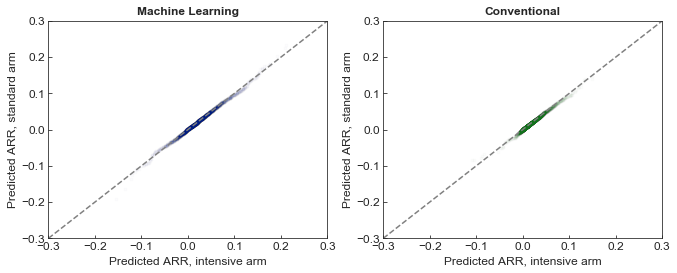

In [149]:
plot_matching_patient_pairs("sprint")